# COSC 6380 - DATA ANALYTICS

## Assignment 2: Hypothesis Testing
### Author: Syed Izzat Ullah
### Date: 02/19/2024
# Hypothesis 1: Average monthly temperature in Corpus Christi follows a normal distribution.
* Null hypothesis (H0): Average monthly temperature in Corpus Christi follows a normal distribution.
* Alternative hypothesis (H1): Average monthly temperature in Corpus Christi does not follows a normal distribution

## Environment Setup

In [1]:
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

## Data Acquisition and Selection

The analysis considers average monthly temperatures in Corpus Christi, Texas, from January 1979 to February 2024.
Daily maximum temperature data for the years 1979-2024 was obtained from the National Oceanic and Atmospheric Administration (NOAA).
Data specific to the Corpus Christi station was extracted to ensure the analysis reflects local temperature patterns.


In [2]:
url_template = "http://psl.noaa.gov/thredds/dodsC/Datasets/cpc_global_temp/tmax.{}.nc"

In [3]:
station_lon = 262.75  # Longitude of Corpus Christi station   262.75
station_lat = 27.75   # Latitude of Corpus Christi station    27.75

In [4]:
data = []
for year in range(1979, 2025):
    url = url_template.format(year)
    
    # Load data using xarray
    dataset = xr.open_dataset(url)
    
    # Select data for Corpus Christi station
    corpus_christi_data = dataset.sel(lon=station_lon, lat=station_lat, method='nearest')
    
    # Extract temperature data
    max_temp = corpus_christi_data['tmax']
    
    # Convert xarray to pandas DataFrame
    df = max_temp.to_pandas().reset_index()
    
    # Add year column
    df['year'] = year
    
    # Append data for each year to a list
    data.append(df)

In [5]:
# Concatenate DataFrames
combined_df = pd.concat(data, ignore_index=True)

# Sorting by date
combined_df = combined_df.sort_values(by=['year', 'time'])
combined_df = combined_df.rename(columns={0: 'tmax'}) #combined_df has temperature values in the "0th" column, here we just rename it to 'tmax'

In [6]:
# Since, it takes significant time to parse the data through the URL, therefore, once parsed I then saved it in a csv file to avoid delay in the future
# combined_df.to_csv("combined_df.csv", index=False) #uncommmend this line only if you wanna save the data

Let's see whats in our DataFrames

In [7]:
print(combined_df.columns)
print(combined_df.info())
print(combined_df['tmax'].describe())

Index(['time', 'tmax', 'year'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16496 entries, 0 to 16495
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    16496 non-null  datetime64[ns]
 1   tmax    16472 non-null  float32       
 2   year    16496 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int64(1)
memory usage: 322.3 KB
None
count    16472.000000
mean        27.783087
std          6.646760
min         -1.158633
25%         24.126266
50%         29.053896
75%         33.025063
max         42.911469
Name: tmax, dtype: float64


Here we create a new column named 'month' that contains the month number (1-12) for each row in the 'time' column.

In [8]:
combined_df['month'] = combined_df['time'].dt.month

In [9]:
#Monthly averages of each month from the daily temperature data
monthly_averages = combined_df.resample('M', on='time')[['year', 'tmax']].mean()

In [10]:
monthly_averages.columns

Index(['year', 'tmax'], dtype='object')

## Data Visualization

### Time series data visualization of maximum temperature in Corpus Christi from 1979-2024

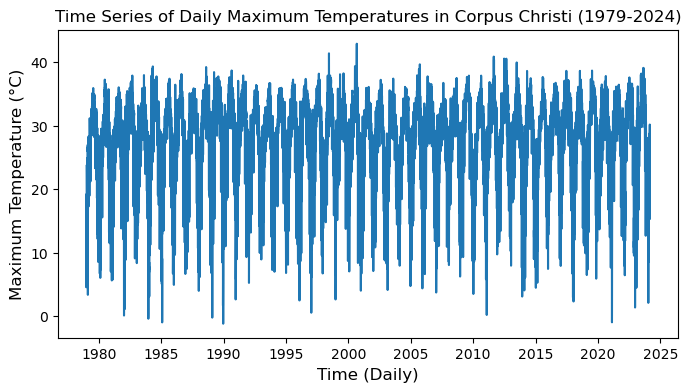

In [15]:
plt.figure(figsize=(8, 4))

# Plotting time series of daily maximum temperatures
plt.plot(combined_df['time'], combined_df['tmax'])
plt.xlabel('Time (Daily)', fontsize=12)
plt.ylabel('Maximum Temperature (°C)', fontsize=12)
plt.title('Time Series of Daily Maximum Temperatures in Corpus Christi (1979-2024)')
# plt.savefig('daily_temperatures.png', dpi=300)
plt.show()


### Heatmap of average monthly temperatures data in corpus christi from 1979 to 2024

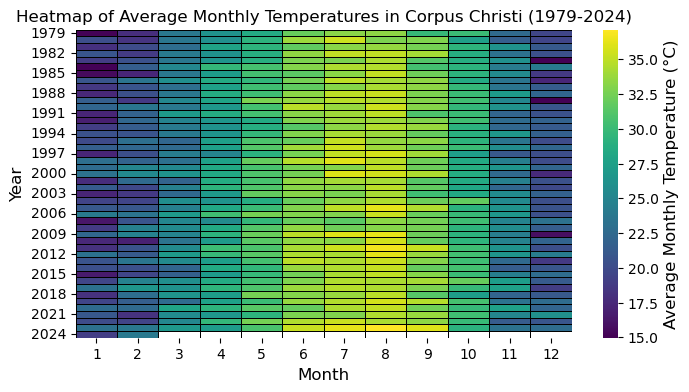

In [17]:
plt.figure(figsize=(8, 4)) 
# heatmap_data = combined_df.pivot(index='year', columns='month', values='tmax')
heatmap_data = combined_df.pivot_table(index='year', columns='month', values='tmax', aggfunc='mean')

heatmap = sns.heatmap(heatmap_data, cmap="viridis", linewidths=0.5, linecolor='black')

plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.title('Heatmap of Average Monthly Temperatures in Corpus Christi (1979-2024)')
colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Average Monthly Temperature (°C)', fontsize=12)
# plt.savefig('monthly_temp_hm.png', dpi=300)  #uncomment if you wanna save the figure

plt.show()


## Normality Testing

Here we Generate a histogram of the average monthly temperatures to assess the shape of the distribution visually. From the Histogram below, we can see that the density plot doesn't resemble a normal distribution. Let's keep analyzing.

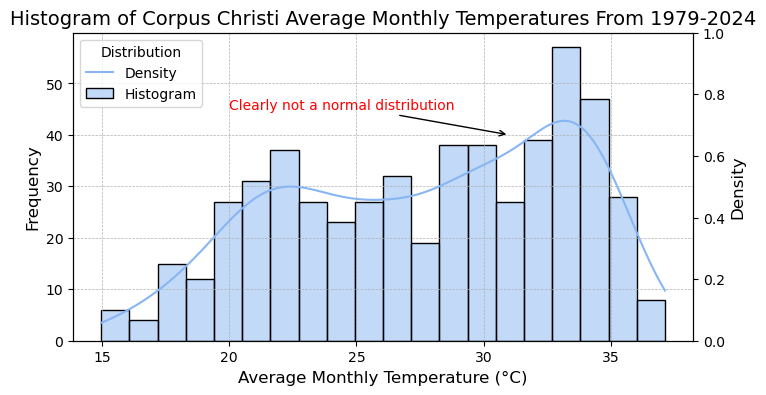

In [19]:
fig, ax = plt.subplots(figsize=(8, 4)) 
sns.histplot(monthly_averages['tmax'], kde=True, bins=20, ax=ax, color='#87B6F3')

ax.set_title('Histogram of Corpus Christi Average Monthly Temperatures From 1979-2024', fontsize=14)
ax.set_xlabel('Average Monthly Temperature (°C)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax.legend(['Density', 'Histogram'], title='Distribution', loc='best', fontsize=10)

# Annotation
ax.annotate('Clearly not a normal distribution', 
            xy=(31, 40), 
            xytext=(20, 45),
            arrowprops=dict(facecolor='red', arrowstyle='->'),
            fontsize=10, color='red')

fig.patch.set_facecolor('white')

# Creating a twin Axes for the density plot
ax2 = ax.twinx()
ax2.set_ylabel('Density', fontsize=12)
plt.yticks(fontsize=10)

# plt.savefig('monthly_temp_hist.png', dpi=300)  #uncommend if you wanna save the figure

plt.show()


Next, we generate a quantile-quantile (QQ) plot to compare the monthly averaged temperature data quantiles to the expected quantiles of a normal distribution. On the QQ plot, if the temperature data fit a 45 degree virtual red line, that would mean that the data follows a normal distribution, or vice-versa.

<Figure size 1000x800 with 0 Axes>

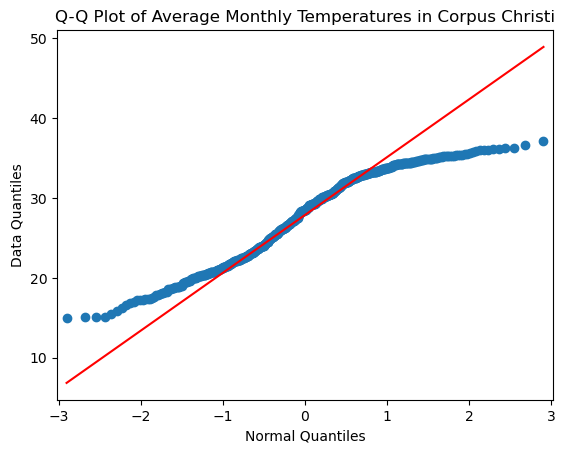

In [23]:
monthly_temps = monthly_averages['tmax']

plt.figure(figsize=(10, 8))

# Generate the Q-Q plot
sm.qqplot(monthly_temps, line='q')
plt.title('Q-Q Plot of Average Monthly Temperatures in Corpus Christi')
plt.xlabel('Normal Quantiles')
plt.ylabel('Data Quantiles')

plt.show()


From the QQ Plot, we saw that the doesn't follow a normal distribution, BUT, lets confirm it from a statistical test such as Shapiro-Wilk test which tells you whether a dataset has normality or not.

In [21]:
monthly_temps = monthly_averages['tmax']
stat, p_value = stats.shapiro(monthly_temps)

print("Shapiro-Wilk test statistic:", stat)
print("p-value:", p_value)


Shapiro-Wilk test statistic: 0.9501882656670504
p-value: 1.519893036062127e-12


## Results:

The visualization of the histogram and QQ plot suggested that the data deviates from a normal distribution. Further, the Shapiro-Wilk test yielded a p-value less than 0.05 which rejects the null hypothesis of normality at a 5% significance level.

**<font color='red'>Based on the above analysis, we reject the Null hypotheses</font>**
